# Collaborative Filtering: Cosine Similarity

## Alex Riley, Apr 23 2018

In another Jupyter Notebook, we applied Collaborative Filtering to a subset of the MovieLens dataset utilizing the Pearson correlation coefficient as the weights for how similar two users were.  Here we will use another metric: the cosine similarity

$$ sim(u,u') = cos(\theta{}) = \frac{\textbf{r}_{u} \dot{} \textbf{r}_{u'}}{\| \textbf{r}_{u} \| \| \textbf{r}_{u'} \|} = \sum_{i} \frac{r_{ui}r_{u'i}}{\sqrt{\sum\limits_{i} r_{ui}^2} \sqrt{\sum\limits_{i} r_{u'i}^2} } $$

We'll take a similar approach as the other notebook

## Load data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from utils import predict_full, train_test_split, mse

# to supress divide by zero or NaN errors that are handled
ignore = np.seterr(divide='ignore', invalid='ignore')

For this notebook we downloaded the subset of the MovieLens dataset that only contains 100,000 ratings

In [2]:
ratings = pd.read_csv('data/ratings.csv',header=0)
ratings = ratings.pivot_table(index='userId',columns='movieId',values='rating')
ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will find it useful when we are calculating similarities later to replace NaNs with 0.0.  It's important to keep in the back of our minds that this is the case, and that 0.0 does not mean a rating of zero stars.

In [3]:
ratings.fillna(value=0.0, inplace=True)

## Split into train/test

We can turn the data into training and test sets by 
* making two copies of the ratings dataframe
* for each user, select a percentage of ratings (removing 0s)
    * in the training data, set these values to 0.0
    * in the test data, set everything else to 0.0

In [4]:
train, test = train_test_split(ratings, empty=0.0, testfrac=0.2)

We can check our work by verifying that ~80% of the entries in each row are in the training set

In [5]:
(train.astype(bool).sum(axis=1)/ratings.astype(bool).sum(axis=1)).head(n=7)

userId
1    0.800000
2    0.802632
3    0.803922
4    0.803922
5    0.800000
6    0.818182
7    0.806818
dtype: float64

## Applying cosine similarity

The cosine similarity is a common metric used in collaborative filtering algorithms.  It can be helpful to visualize each user's ratings as a vector &mdash; the cosine of the angle between vectors gives some measure of similarity between the two.

$$ sim(u,u') = cos(\theta{}) = \frac{\textbf{r}_{u} \dot{} \textbf{r}_{u'}}{\| \textbf{r}_{u} \| \| \textbf{r}_{u'} \|} = \sum_{i} \frac{r_{ui}r_{u'i}}{\sqrt{\sum\limits_{i} r_{ui}^2} \sqrt{\sum\limits_{i} r_{u'i}^2} } $$

Given the middle formula, with a matrix composed of vectors it's easy to see as the dot product between the matrix and its transpose, divided by the product of norms and norms transposed.

Additionally, when computing cosine similarities we will subtract the mean rating for each user. Pearson correlation does this by definition, and we find that our results improve slightly. This is sometimes referred to as Adjusted Cosine in the literature.

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_sim(df):
    vals = df.values
    sim = vals @ vals.T
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

def cosine_sim_adj(df):
    # above code returns same numerical results as cosine_similarity
    # but throws warnings/nans that are set to 0 in sklearn's version
    df_centered = df.replace(0.0, np.nan)
    df_centered -= df_centered.mean(axis=1)
    df_centered.fillna(value=0.0, inplace=True)
    
    return cosine_similarity(df_centered)

In [7]:
similarity = cosine_sim(train)
similarity[:5, :5]

array([[1.        , 0.        , 0.        , 0.08232528, 0.02036295],
       [0.        , 1.        , 0.0713214 , 0.07416615, 0.01987354],
       [0.        , 0.0713214 , 1.        , 0.08477334, 0.12145402],
       [0.08232528, 0.07416615, 0.08477334, 1.        , 0.0733066 ],
       [0.02036295, 0.01987354, 0.12145402, 0.0733066 , 1.        ]])

As we can see, we get a weighting factor that is symmetric with the diagonal equal to 1 (corresponding to the $\cos(\theta)$ of a vector with itself).  Higher values of $\cos(\theta)$ indicate a stronger impact.  We can plot the distribution of weights in both linear and log-space bins (note this is very rough, since non-diagonal values are counted twice)

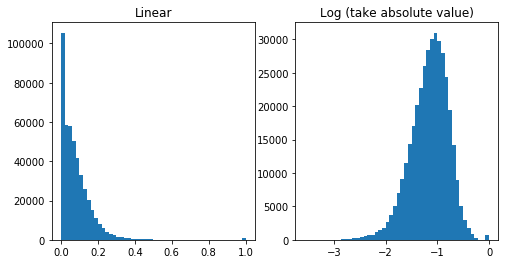

In [8]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(similarity.flatten(), bins=50)
plt.title('Linear')

plt.subplot(1,2,2)
plt.hist(np.log10(np.abs(similarity[similarity != 0].flatten())), bins=50)
plt.title('Log (take absolute value)');

## Predicting ratings

Now that our weights are computed, we can assign a predicted rating to the test set and see how well we did

In [9]:
prediction = predict_full(train, similarity)

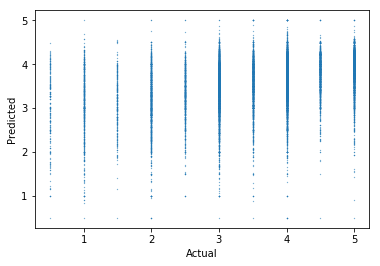

In [10]:
plt.plot(test.values[test.values > 0], prediction.values[test.values > 0], '.', ms=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted');

At first glance this doesn't look very good, but it's actually quite improved from previous attempts at this code (mostly fixed by only including users who rated a given movie when computing predictions). For the sake of comparison to the Pearson correlation scheme, let's compute the MSE

In [11]:
mse(pred=prediction, actual=test)

0.9797260056844873

This is only slightly worse than the Pearson correlation method (which had an MSE of ~0.95 depending on the draw from the train/test split). The two seem to do nearly the same with these data.

## Tested on Alex's ratings

We'll import and format Alex's ratings

In [12]:
mine = pd.read_csv('processed/alex_ratings.csv',header=0)
mine['movieId'] = [int(a) for a in mine['movieId']]
mine['userId'] = 1000
mine.drop(columns='user',inplace=True)
mine = mine.loc[mine['movieId']>0]
mine

,movieId,rating,timestamp,userId
23,74458,3.0,0.0,1000
47,71264,4.0,0.0,1000
77,113378,4.0,0.0,1000
96,63515,2.0,0.0,1000
107,8827,4.0,0.0,1000
110,120635,0.5,0.0,1000
112,117176,3.5,0.0,1000
114,30816,5.0,0.0,1000
121,39435,3.5,0.0,1000
138,6663,4.5,0.0,1000


and then combine them with the original ratings set (notice Alex's ratings are under `userId = 1000`)

In [13]:
ratings = pd.read_csv('data/ratings.csv',header=0)
ratings = pd.concat([ratings,mine],ignore_index=True)
ratings = ratings.pivot_table(index='movieId',columns='userId',values='rating')
ratings.head()

userId,1,2,3,4,5,6,7,8,9,10,...,663,664,665,666,667,668,669,670,671,1000
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For expediency, we won't bother splitting into a train/test set.  Instead we will calculate the Cosine similarity between all users and then use those to predict Alex's ratings

In [14]:
ratings.fillna(0, inplace=True)
similarity = cosine_sim(ratings)
similarity[:5, :5]

array([[1.        , 0.39451145, 0.30651588, 0.1336141 , 0.24510196],
       [0.39451145, 1.        , 0.21749153, 0.16465129, 0.27847624],
       [0.30651588, 0.21749153, 1.        , 0.17701184, 0.37073234],
       [0.1336141 , 0.16465129, 0.17701184, 1.        , 0.17955647],
       [0.24510196, 0.27847624, 0.37073234, 0.17955647, 1.        ]])

In [15]:
prediction = predict_full(ratings, similarity)
alex_pred = prediction[1000].sort_values(ascending=False)
movies = pd.read_csv('data/movies.csv', index_col='movieId')
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


We can take a look at what the highest-recommended movies are

In [16]:
movies.loc[alex_pred.index[:5]]

,title,genres
movieId,,
49647,Charlotte's Web (2006),Children|Comedy|Drama|Fantasy
4046,Friendly Persuasion (1956),Drama
6983,Jane Eyre (1944),Drama|Romance
4319,Apache (1954),Western
4324,"Kentuckian, The (1955)",Drama|Western


Interesting choices.  Charlotte's Web is probably due to Alex's rating of a bunch of childhood movies, and we see the tendency for Drama movies to appear high. Let's see the least recommended

In [17]:
movies.loc[alex_pred.index[:-5-1:-1]]

,title,genres
movieId,,
162672,Mohenjo Daro (2016),Adventure|Drama|Romance
162542,Rustom (2016),Romance|Thriller
158314,Daniel Tosh: Completely Serious (2007),Comedy
156025,Ice Age: The Great Egg-Scapade (2016),Adventure|Animation|Children|Comedy
155611,Life Is Sacred (2014),Documentary


Alex didn't rate many comedies so this makes some amount of sense as well.